### Reconocimiento facial: Clasificación mediante SVM

In [1]:
from sklearn.datasets import fetch_lfw_people # Importamos un dataset de sklearn
import matplotlib.pyplot as plt

#from jupyterthemes import jtplot
#jtplot.style(theme='onedork')

In [2]:
faces = fetch_lfw_people(min_faces_per_person = 60) # Descargamos 60 caras por persona

In [3]:
print(faces.target_names) # Personas que aparecen en las fotografías

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']


In [4]:
print(faces.images.shape) # 1348 imágenes, pixeles de altura, pixeles de anchura

(1348, 62, 47)


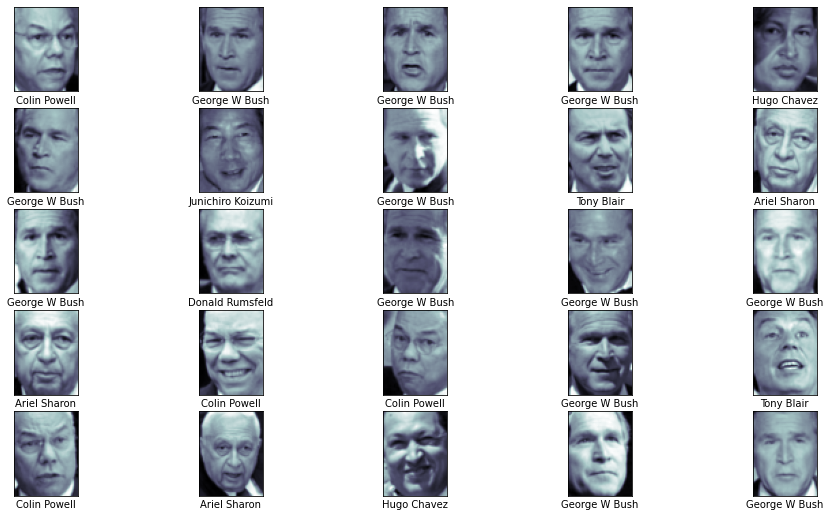

In [5]:
# Gráfica de las fotografías
fig, ax = plt.subplots(5, 5, figsize = (16, 9)) # Realizamos una matriz 5x5 de imágenes 
for i, ax_i in enumerate(ax.flat): # Enumeramos el índice de cada imágenes
    ax_i.imshow(faces.images[i], cmap = "bone") # Graficamos la imagen[i]
    # Sin ejes en x ni y, incorporamos nombre en la posición indicada 
    ax_i.set(xticks = [], yticks = [], xlabel = faces.target_names[faces.target[i]])

In [6]:
62*47 # Cada imágen tiene 2914 pixeles
# Toca reducir las dimensiones, tomamos las 250 características más importantes

2914

In [7]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline # Encadena instrucciones 1 tras otras

In [8]:
pca = RandomizedPCA(n_components = 150, whiten = True, random_state = 42)
svc = SVC(kernel = "rbf", class_weight = "balanced") # Kernel radial basic function
# En estas imágnees conviene obtener rasgos circulares 
model = make_pipeline(pca, svc) # Ponderación de los rasgos más importantes

In [9]:
# Validación cruzada
from sklearn.model_selection import train_test_split

In [10]:
# Dividimos nuestra data en conjunto de entranamiento y testeo
xtrain, xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state = 42)

In [11]:
# Búsqueda del mejor modelo
from sklearn.model_selection import GridSearchCV # Parrilla

In [12]:
param_grid = {
    "svc__C": [0.1, 1, 5, 10, 50], # Parámetro C
    "svc__gamma": [0.0001, 0.0005, 0.001, 0.005, 0.01] # Parámetro gamma
}

# model: Análisis de componente principal, clasificador vectorial
# param_grid: Validación cruzada con la lista de parámetros
grid = GridSearchCV(model, param_grid)
%time grid.fit(xtrain, ytrain) # ¿Cúanto tiempo tarde?

Wall time: 50.3 s


GridSearchCV(estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=150, random_state=42,
                                            whiten=True)),
                                       ('svc', SVC(class_weight='balanced'))]),
             param_grid={'svc__C': [0.1, 1, 5, 10, 50],
                         'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01]})

In [13]:
print(grid.best_params_) # Imprimimos los mejores parámetros

{'svc__C': 10, 'svc__gamma': 0.001}


In [14]:
# Ejecutamos nuestro conjunto de test
classifier = grid.best_estimator_
yfit = classifier.predict(xtest)

Text(0.5, 0.98, 'Prediciones de las imágenes (incorrectas en rojo)')

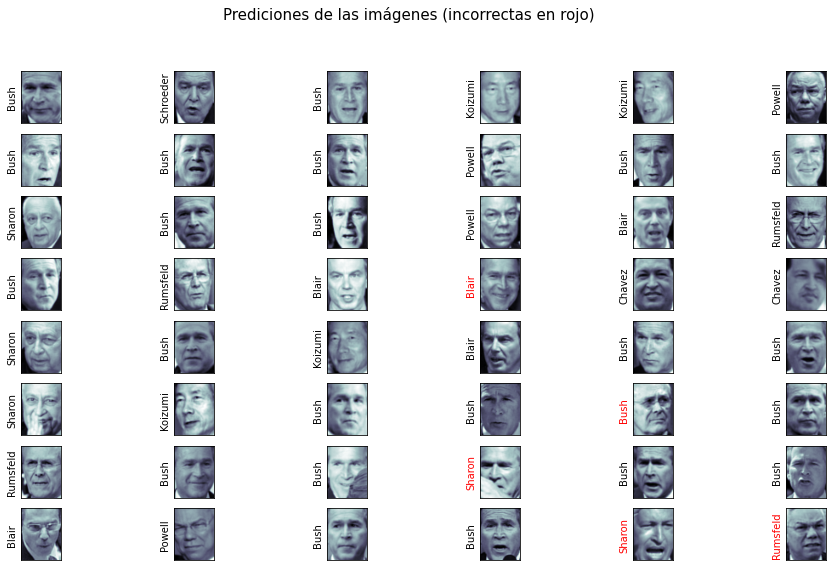

In [15]:
fig, ax = plt.subplots(8, 6, figsize = (16, 9)) # Matriz 8x6 de las imágenes

for i, ax_i in enumerate(ax.flat):
    ax_i.imshow(xtest[i].reshape(62, 47), cmap = "bone")
    ax_i.set(xticks = [], yticks = []) # No graficamos los ejes x, y
    # Graficamos el nombre de la posición i-ésima
    ax_i.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color = "black" if yfit[i] == ytest[i] else "red")
    
fig.suptitle("Prediciones de las imágenes (incorrectas en rojo)", size = 15)

In [16]:
# Librería para generar un reporte de la eficiencia de nuestro clasfiicador
from sklearn.metrics import classification_report

In [17]:
print(classification_report(ytest, yfit, target_names = faces.target_names))
# Precisión - Sensibilidad (1-falsos negativos)

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



In [18]:
# Importamos librería para la matriz de confusión
from sklearn.metrics import confusion_matrix

In [19]:
mat = confusion_matrix(ytest, yfit) # Parámetros de nuestra matriz de confusión

In [20]:
mat # Visualización

array([[ 11,   1,   2,   1,   0,   0,   0,   0],
       [  2,  59,   2,   3,   0,   0,   0,   2],
       [  1,   2,  26,   1,   0,   0,   0,   1],
       [  2,  11,   3, 105,   2,   1,   0,   2],
       [  0,   0,   1,   1,  19,   0,   1,   1],
       [  1,   1,   0,   2,   1,  14,   0,   1],
       [  0,   0,   0,   0,   0,   0,  12,   0],
       [  0,   0,   1,   1,   0,   0,   0,  40]], dtype=int64)

In [21]:
import seaborn as sns; sns.set() # Librería para generar un mapa de calor

<AxesSubplot:>

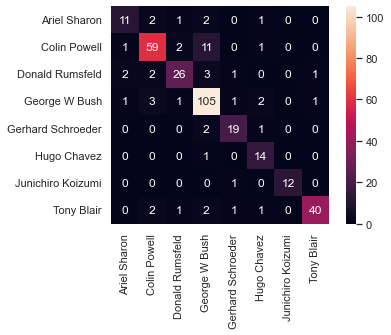

In [22]:
# Matriz de confusión en formato tupla, cuadrado, anotaciones,  fmt, barra lateral
sns.heatmap(mat.T, square = True, annot = True, fmt = "d", cbar = True,
             xticklabels = faces.target_names, yticklabels = faces.target_names)
# Clasificaciones correctas -> Diagonal